# Single-cell RNA-seqs analysis using Python  
## Practicals 02: Dimensionality reduction, clustering, and annotation

Adapted from:  
Single-cell best practices  
www.sc-best-practices.org

Activate `sc_py_training` with the following before opening this notebook.  
```
conda activate sc_py_training
```

and then to open the notebook type 

```
jupyter notebook
```

### Import scanpy library and set up the general settings


In [ ]:
import scanpy as sc

sc.settings.verbosity = 2
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

### Load the anndata object from the previous practical ( after the feature selection step ) 

In [ ]:
adata = sc.read(
    filename="s4d8_feature_selection.h5ad",
    backup_url="https://figshare.com/ndownloader/files/40016014",
)

In [ ]:
adata

## 1.  Dimensionality Reduction


In [ ]:
adata.X = adata.layers["log1p_norm"]

### 1.1 PCA

In [ ]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

In [ ]:
adata

In [ ]:
sc.pl.pca(adata, color="total_counts")
sc.pl.pca(adata, color="PARK7")
sc.pl.pca_variance_ratio(adata, log=True)

## 1.2 t-SNE

In [ ]:
sc.tl.tsne(adata, use_rep="X_pca")

In [ ]:
sc.pl.tsne(adata, color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"])

## 2.3 UMAP

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color="total_counts")

#### 2.3.1 Inspecting quality control metrics on UMAP representation

In [ ]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

In [ ]:
#at this point we might want to remove doublets if we haven't done that earlier in our analysis 
#adata = adata[adata.obs["scDblFinder_class"]=="singlet",]

In [ ]:
adata.write("s4d8_dimensionality_reduction.h5ad") #PCA,UMAP and tsne representations are added

## 2. Clustering

In [ ]:
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=80, facecolor="white", frameon=False)

In [ ]:
# But where is s4d8_subset_gex.h5ad from?
# Load raw count data again 
adata = sc.read("s4d8_dimensionality_reduction.h5ad")

In [ ]:
adata.X = adata.layers["log1p_norm"]

In [ ]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

In [ ]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

In [ ]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

## 3. Annotation

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [5]:
sc.set_figure_params(figsize=(5, 5))

In [6]:
adata = sc.read(
    filename="s4d8_clustered.h5ad",
    backup_url="https://figshare.com/ndownloader/files/41436666",
)

In [7]:
adata

AnnData object with n_obs × n_vars = 9370 × 31208
    obs: 'site', 'donor', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'DF_score', 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_deviant'
    layers: 'scran_normalization'

In [8]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "ID2-hi myeloid prog": [
        "CD14",
        "ID2",
        "VCAN",
        "S100A9",
        "CLEC12A",
        "KLF4",
        "PLAUR",
    ],
    "cDC1": ["CLEC9A", "CADM1"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "GRIK4", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": [
        "VPREB1",
        "MME",
        "EBF1",
        "SSBP2",
        "BACH2",
        "CD79B",
        "IGHM",
        "PAX5",
        "PRKCE",
        "DNTT",
        "IGLL1",
    ],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B1 B": [
        "MS4A1",
        "SSPN",
        "ITGB1",
        "EPHA4",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "CD38",
        "XBP1",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
        "ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],#Hematopoietic stem cells
    "MK/E prog": [
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1",
    ],  # Note PLCB1 is a negative marker #Megakaryocytic-erythroid progenitors
}

In [9]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [10]:
adata.layers["counts"] = adata.X
adata.X = adata.layers["scran_normalization"]

In [11]:
adata.var["highly_variable"] = adata.var["highly_deviant"]

In [12]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [13]:
sc.pp.neighbors(adata)

In [14]:
sc.tl.umap(adata)

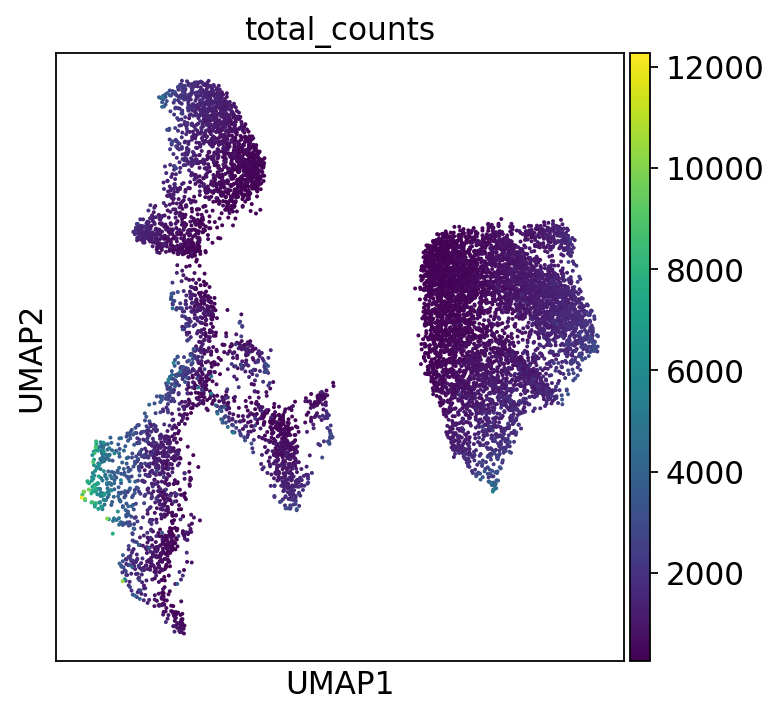

In [15]:
sc.pl.umap(adata,color="total_counts")

In [16]:
marker_genes

{'CD14+ Mono': ['FCN1', 'CD14'],
 'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
 'ID2-hi myeloid prog': ['CD14',
  'ID2',
  'VCAN',
  'S100A9',
  'CLEC12A',
  'KLF4',
  'PLAUR'],
 'cDC1': ['CLEC9A', 'CADM1'],
 'cDC2': ['CST3', 'COTL1', 'LYZ', 'DMXL2', 'CLEC10A', 'FCER1A'],
 'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
 'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
 'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'],
 'NK': ['GNLY',
  'NKG7',
  'CD247',
  'GRIK4',
  'FCER1G',
  'TYROBP',
  'KLRG1',
  'FCGR3A'],
 'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
 'Lymph prog': ['VPREB1',
  'MME',
  'EBF1',
  'SSBP2',
  'BACH2',
  'CD79B',
  'IGHM',
  'PAX5',
  'PRKCE',
  'DNTT',
  'IGLL1'],
 'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
 'B1 B': ['MS4A1',
  'SSPN',
  'ITGB1',
  'EPHA4',
  'COL4A4',
  'PRDM1',
  'IRF4',
  'CD38',
  'XBP1',
  'PAX5',
  'BCL11A',
  'BLK',
  'IGHD',
  'IGHM',
  'ZNF215'],
 'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],


In [17]:
B_plasma_cts = [
    "Naive CD20+ B",
    "B1 B",
    "Transitional B",
    "Plasma cells",
    "Plasmablast",
]

NAIVE CD20+ B:


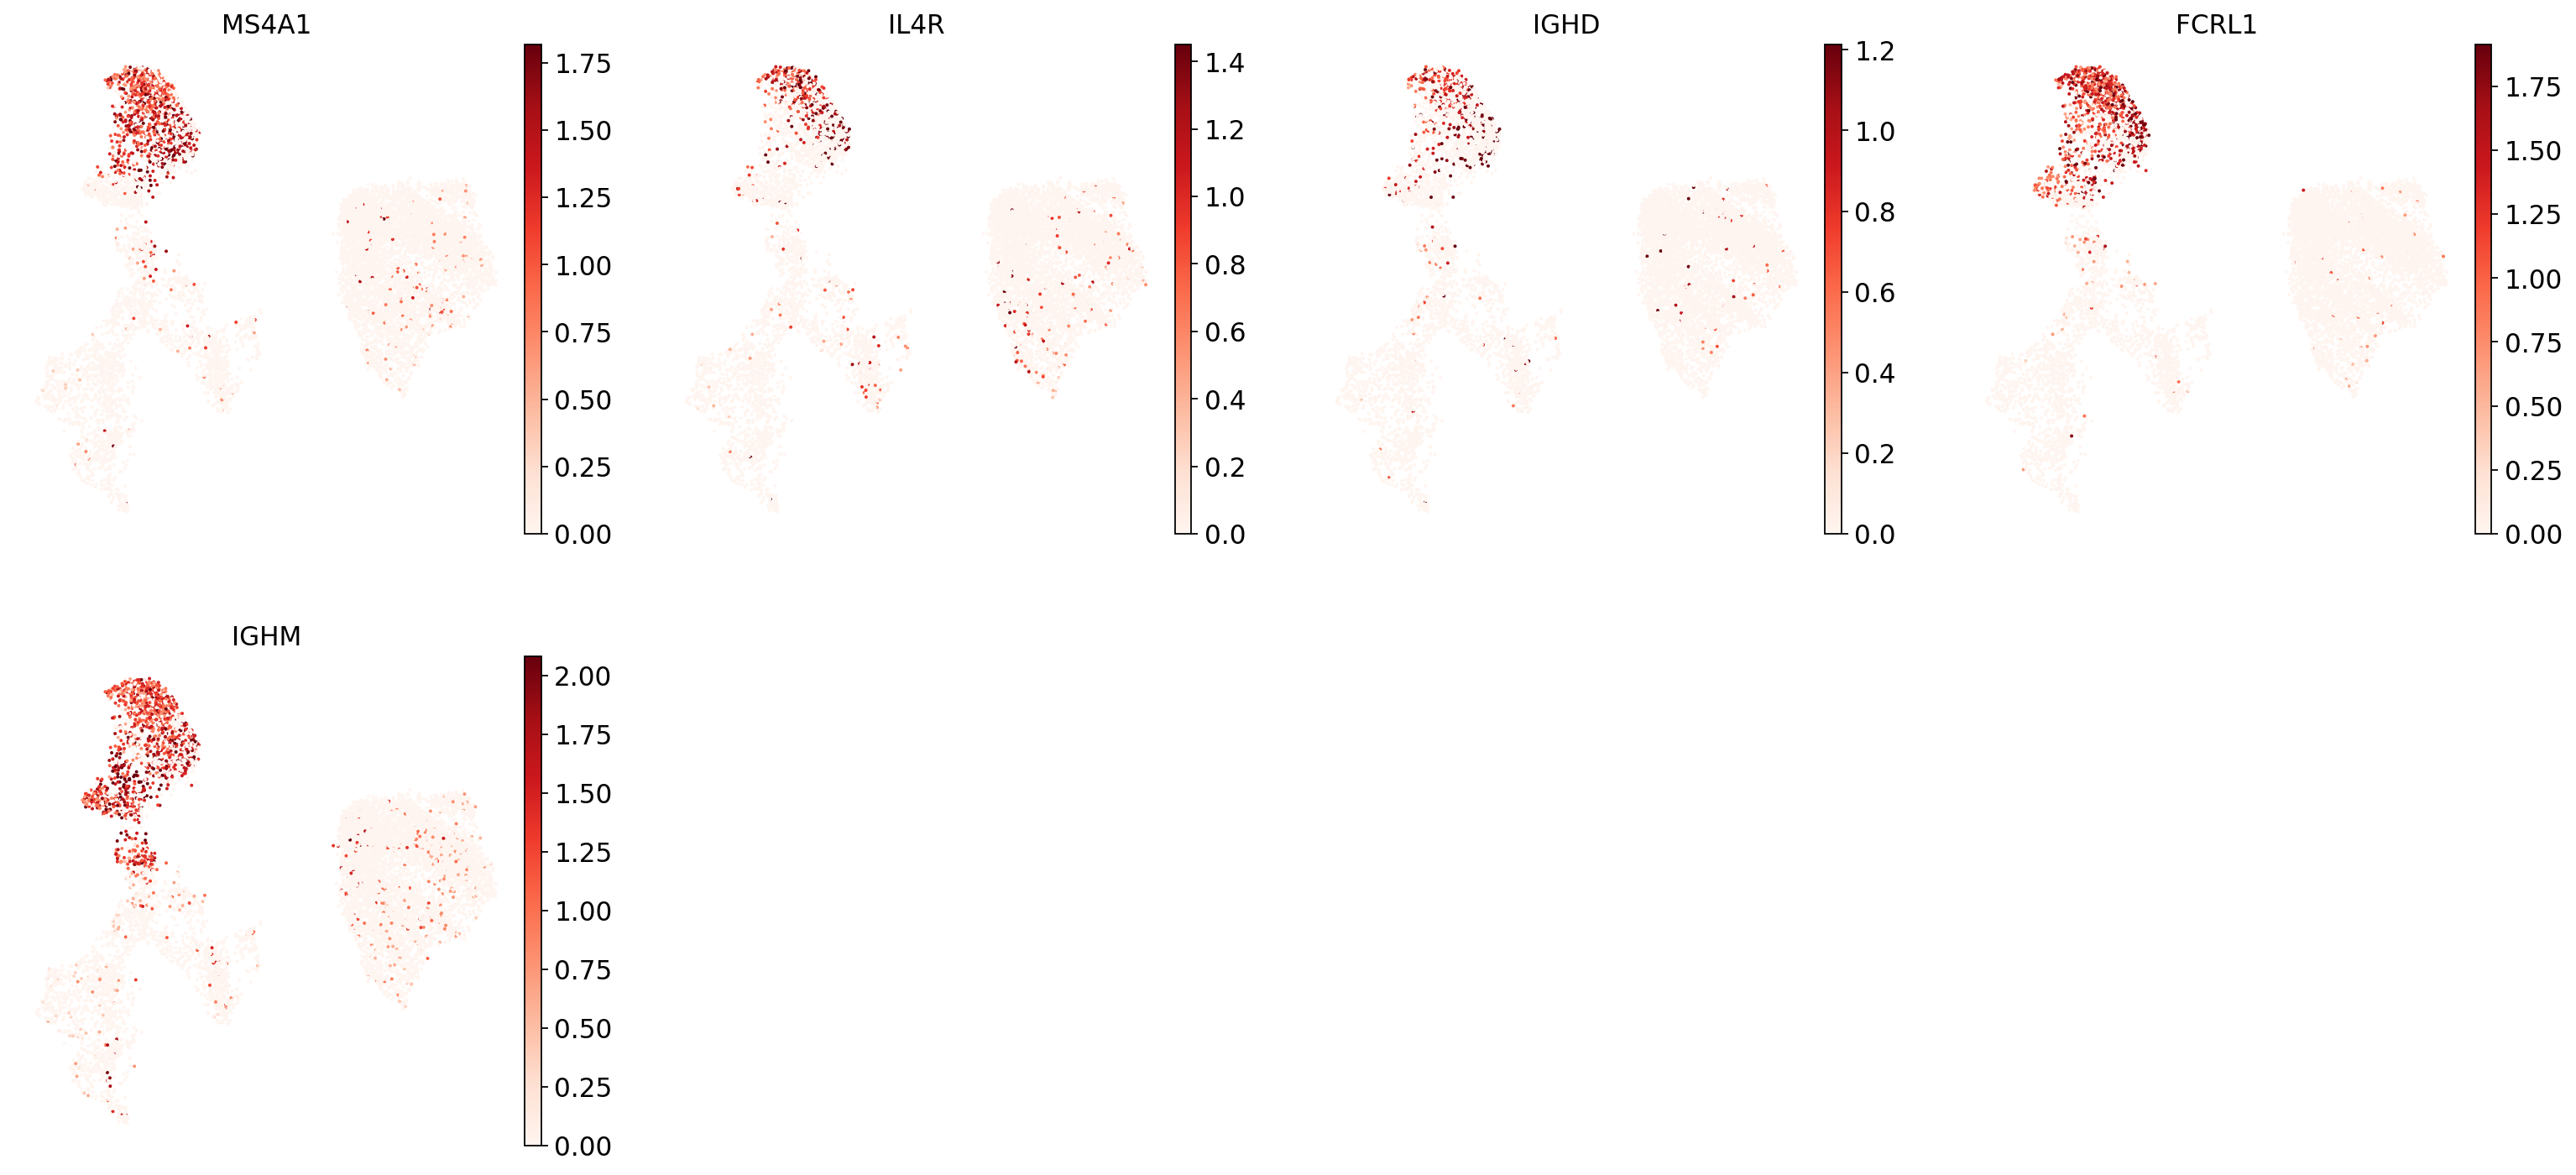





B1 B:


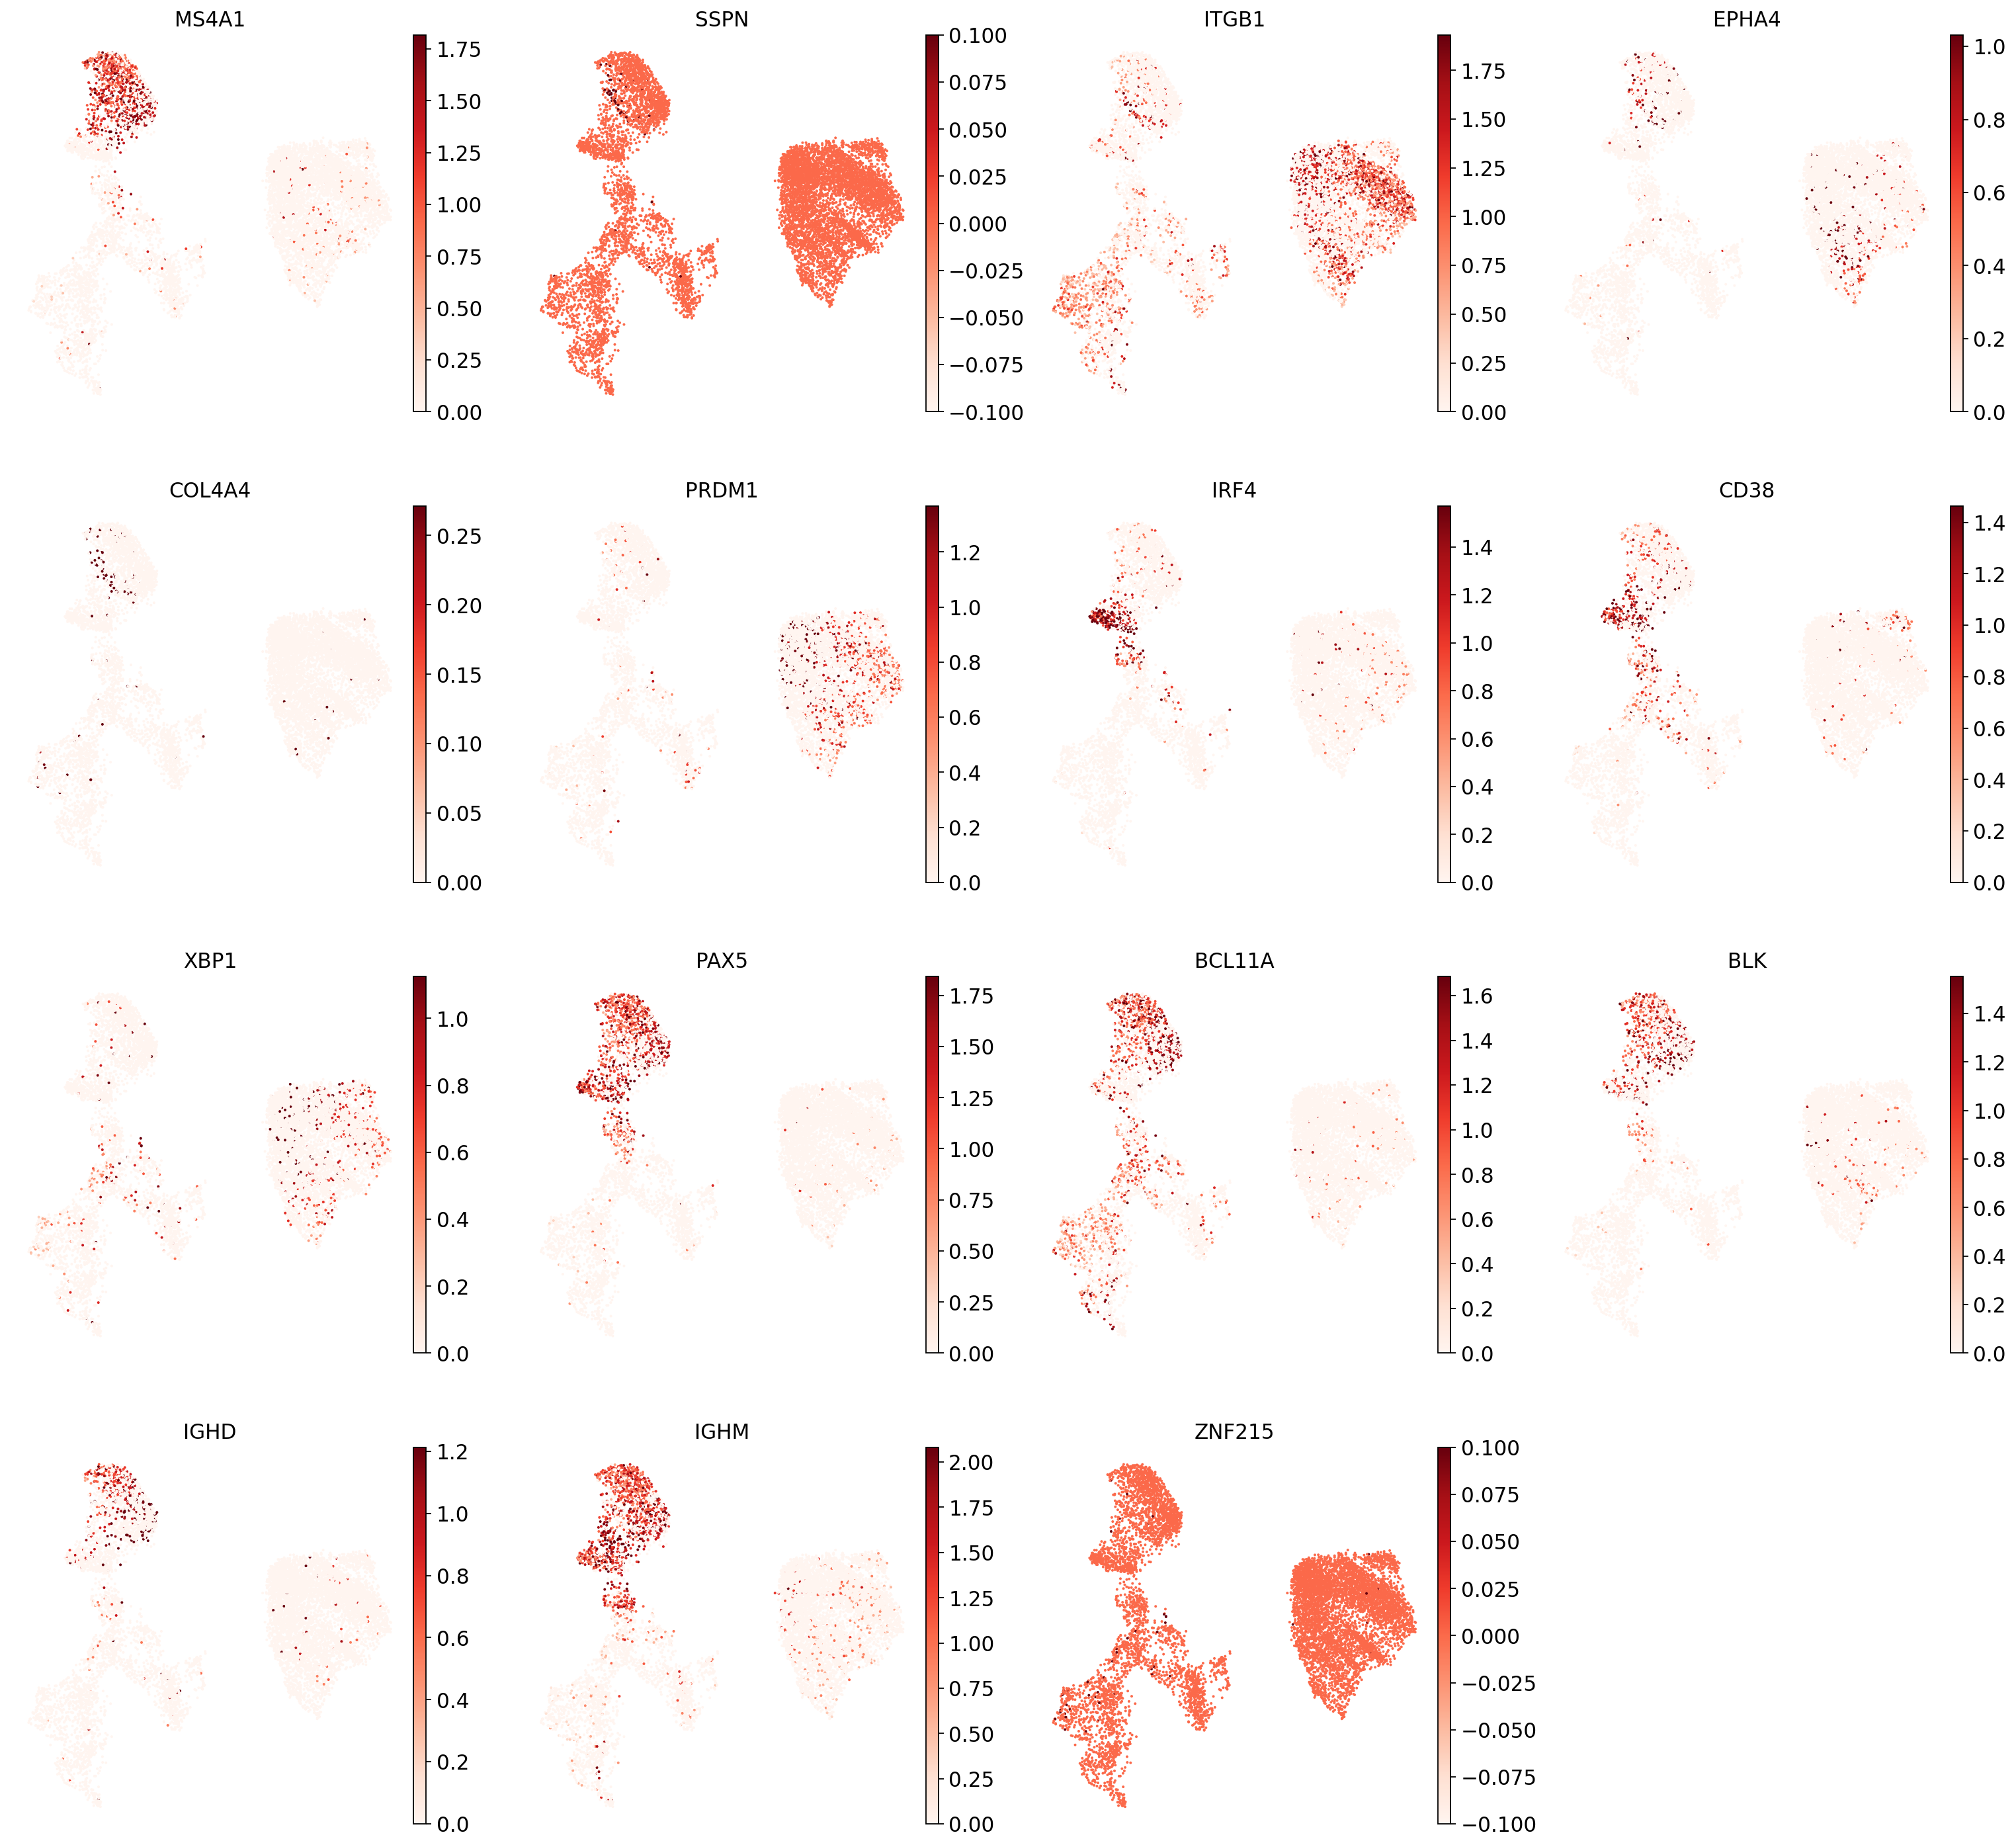





TRANSITIONAL B:


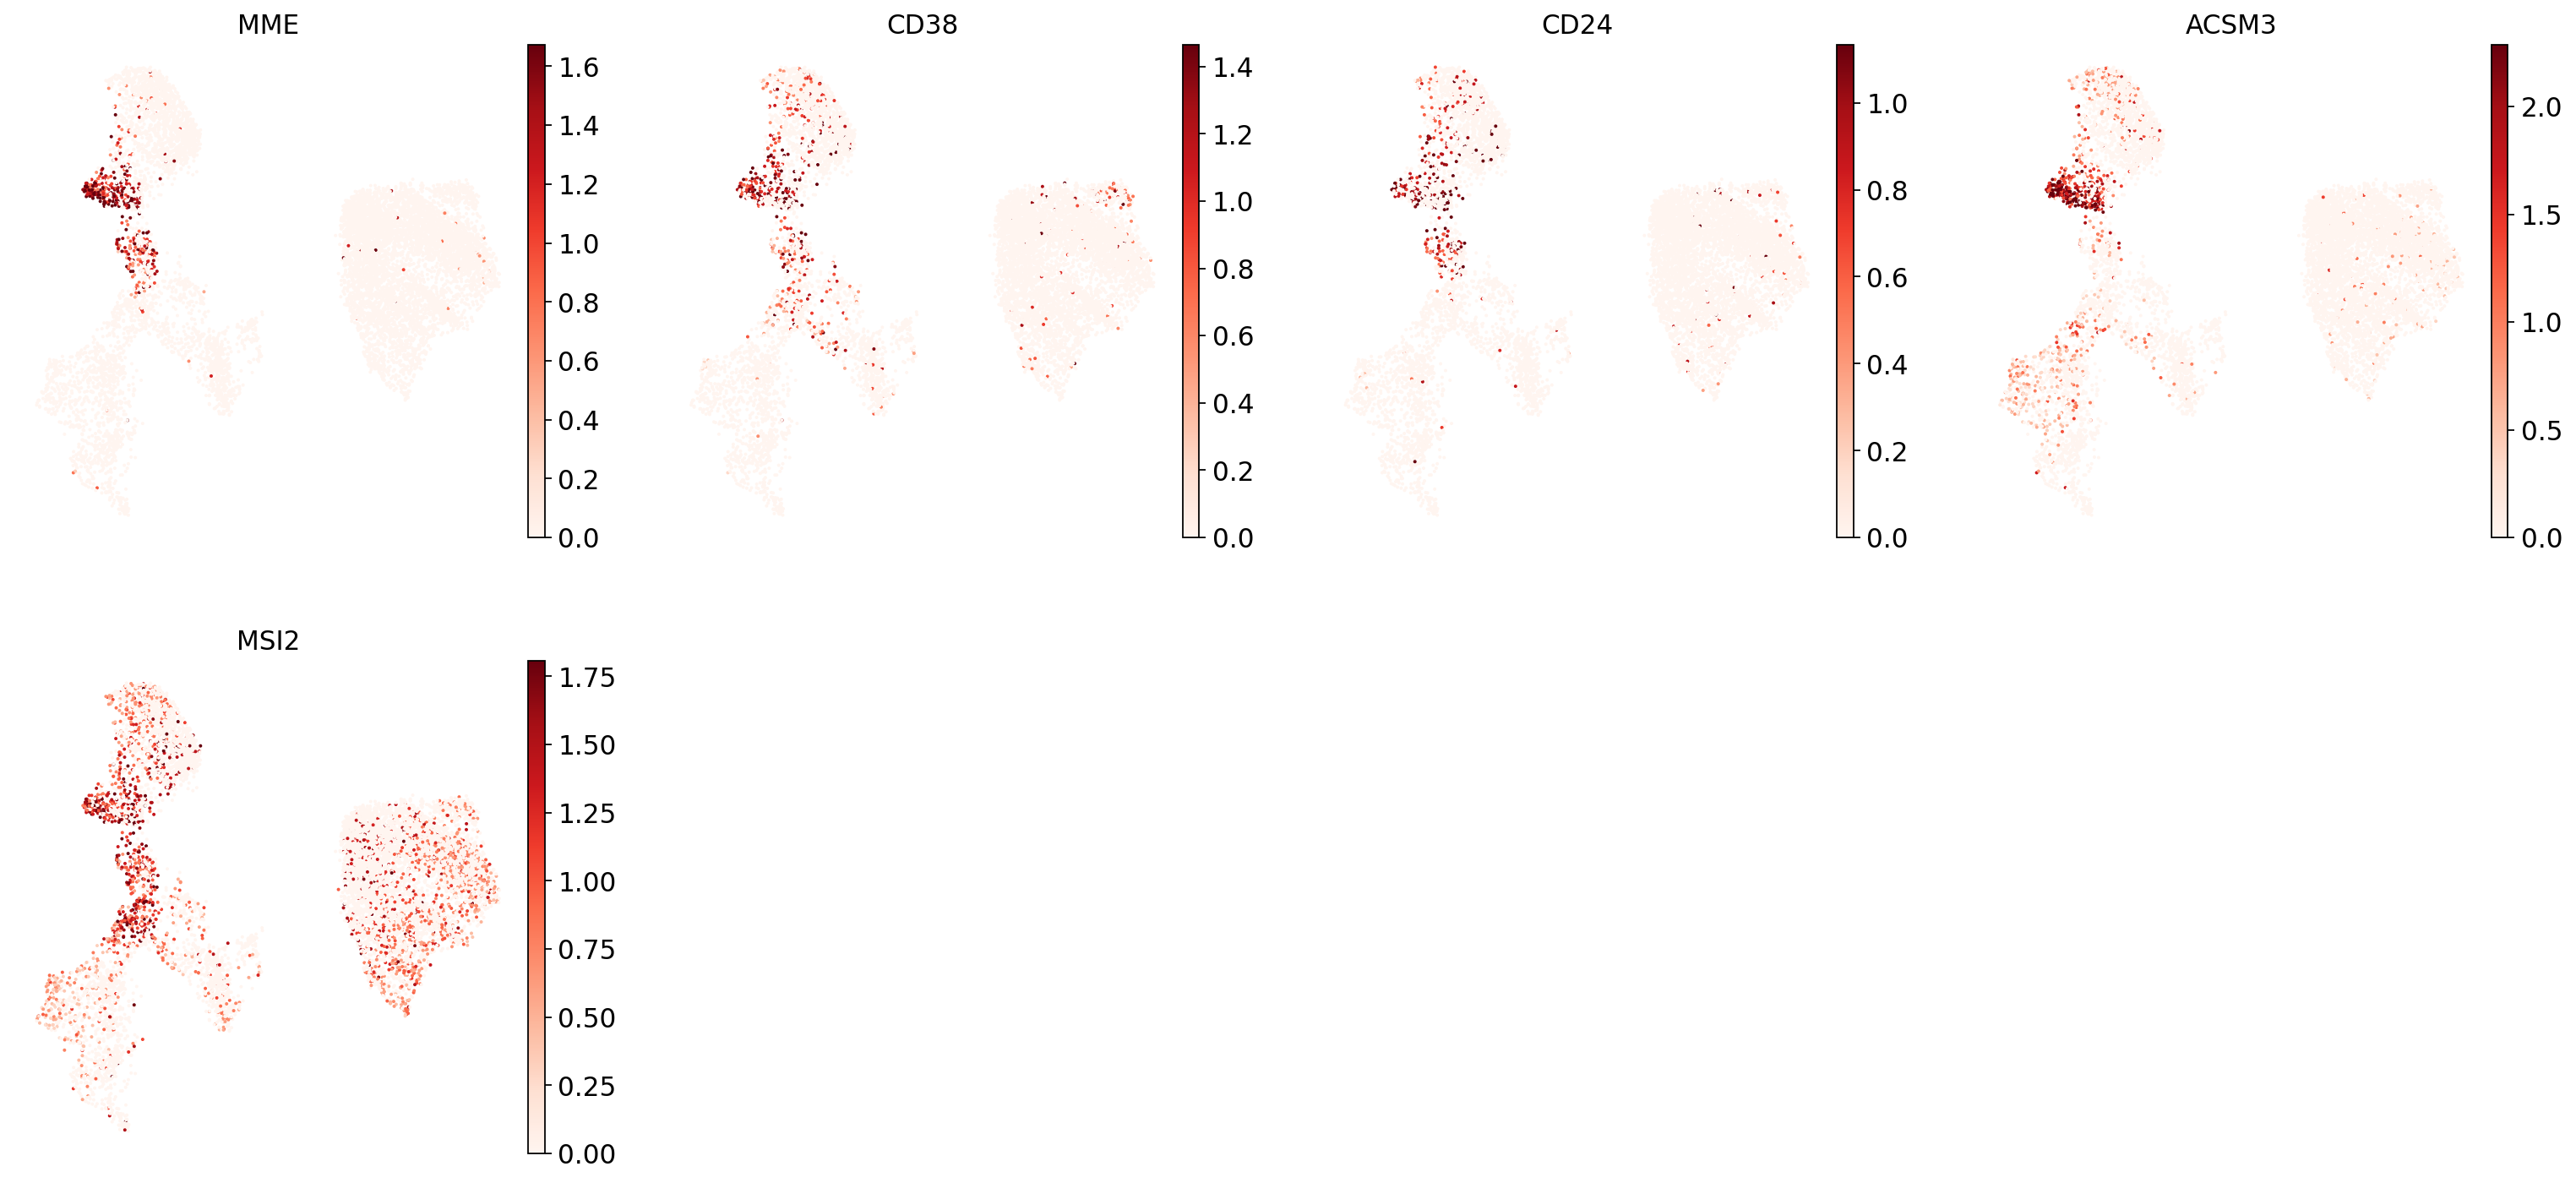





PLASMA CELLS:


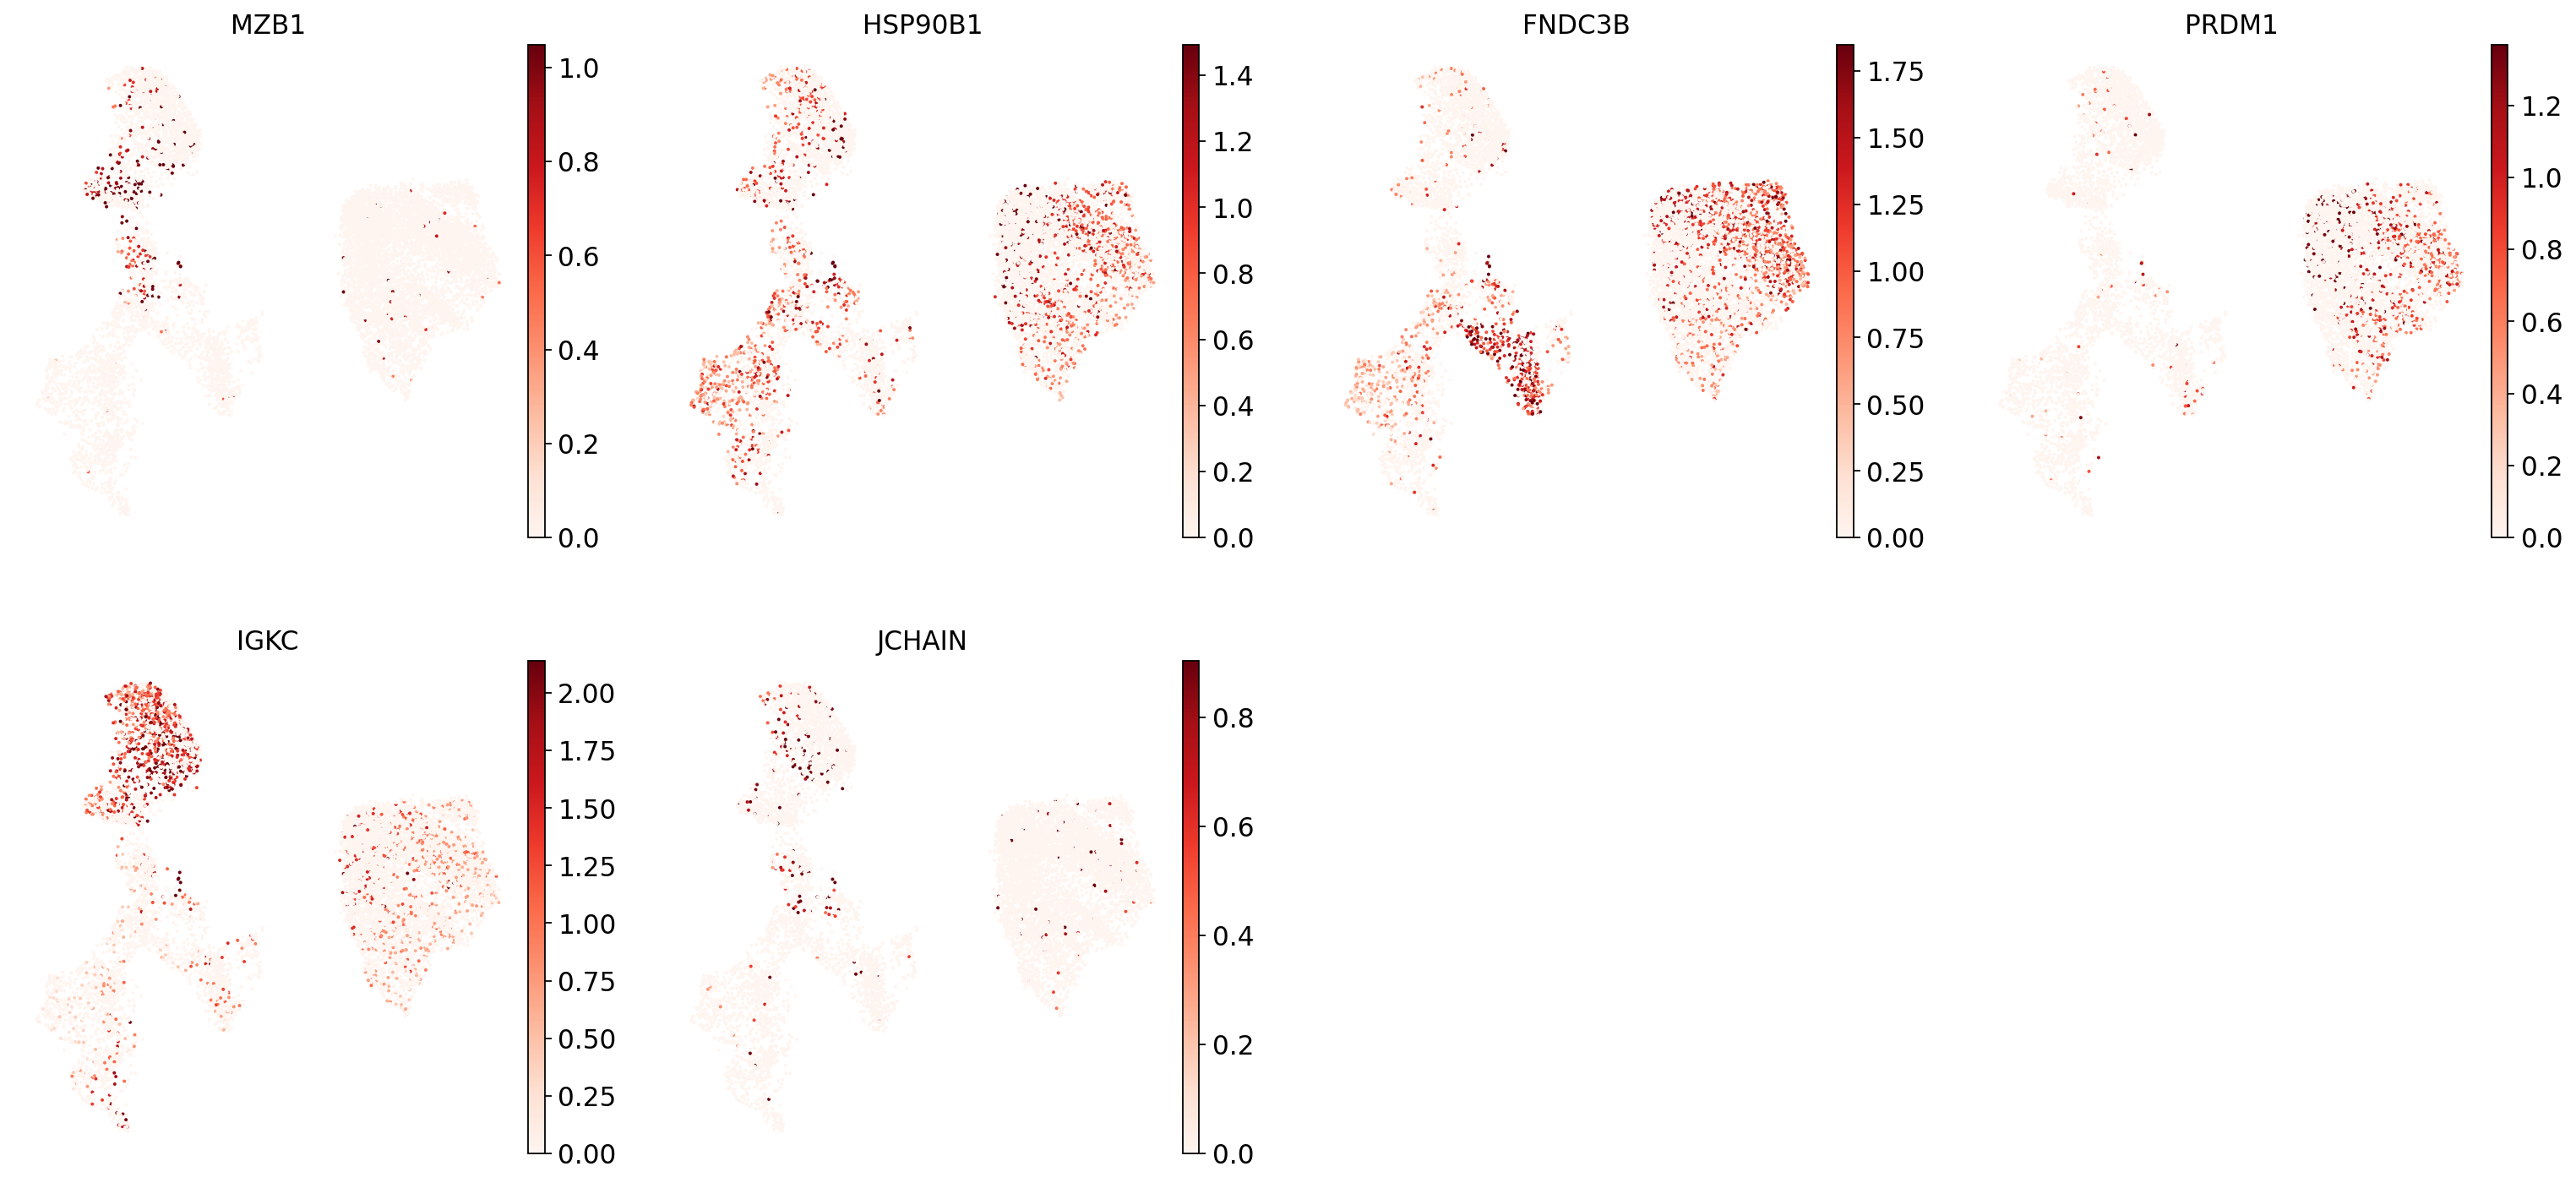





PLASMABLAST:


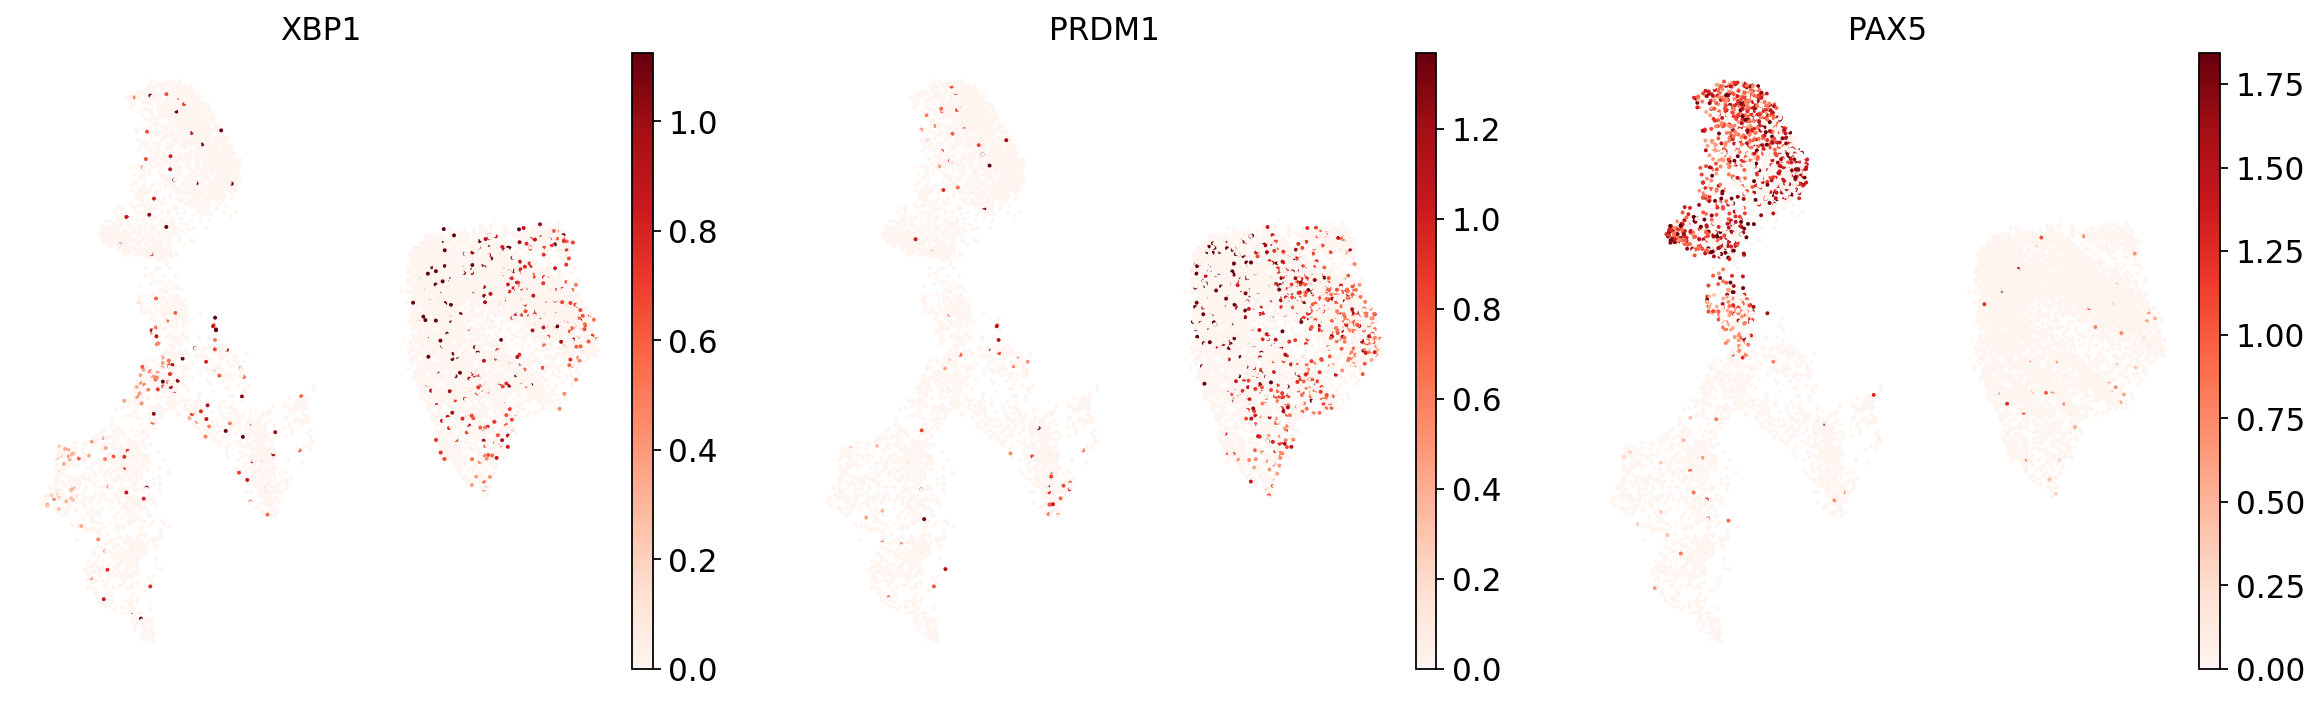

In [18]:
for ct in B_plasma_cts:
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility

In [19]:
sc.tl.leiden(adata, resolution=1, key_added="leiden_1")

/hps/software/users/ma/research/annavp/miniconda3/envs/sc_py_training/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


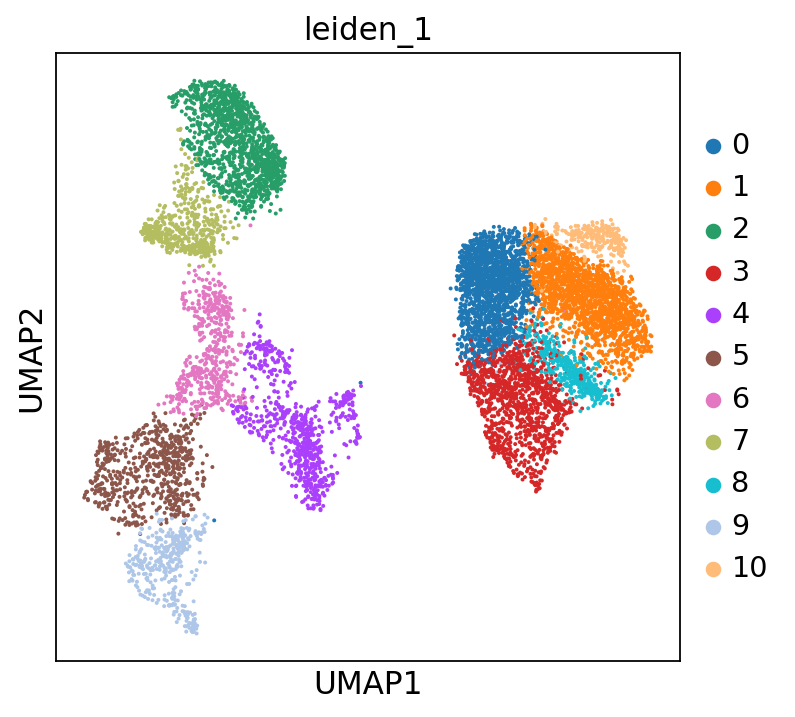

In [20]:
sc.pl.umap(adata, color="leiden_1")

In [21]:
sc.tl.leiden(adata, resolution=2, key_added="leiden_2")

/hps/software/users/ma/research/annavp/miniconda3/envs/sc_py_training/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


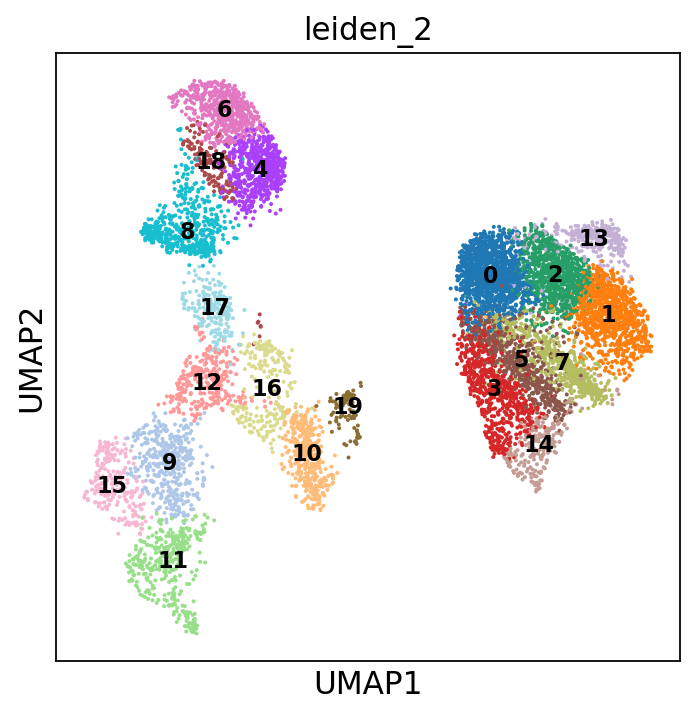

In [22]:
sc.pl.umap(adata, color="leiden_2",legend_loc="on data",legend_fontsize=10)

In [24]:
B_plasma_markers = {
    ct: [m for m in ct_markers if m in adata.var.index]
    for ct, ct_markers in marker_genes.items()
    if ct in B_plasma_cts
}

/hps/software/users/ma/research/annavp/miniconda3/envs/sc_py_training/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


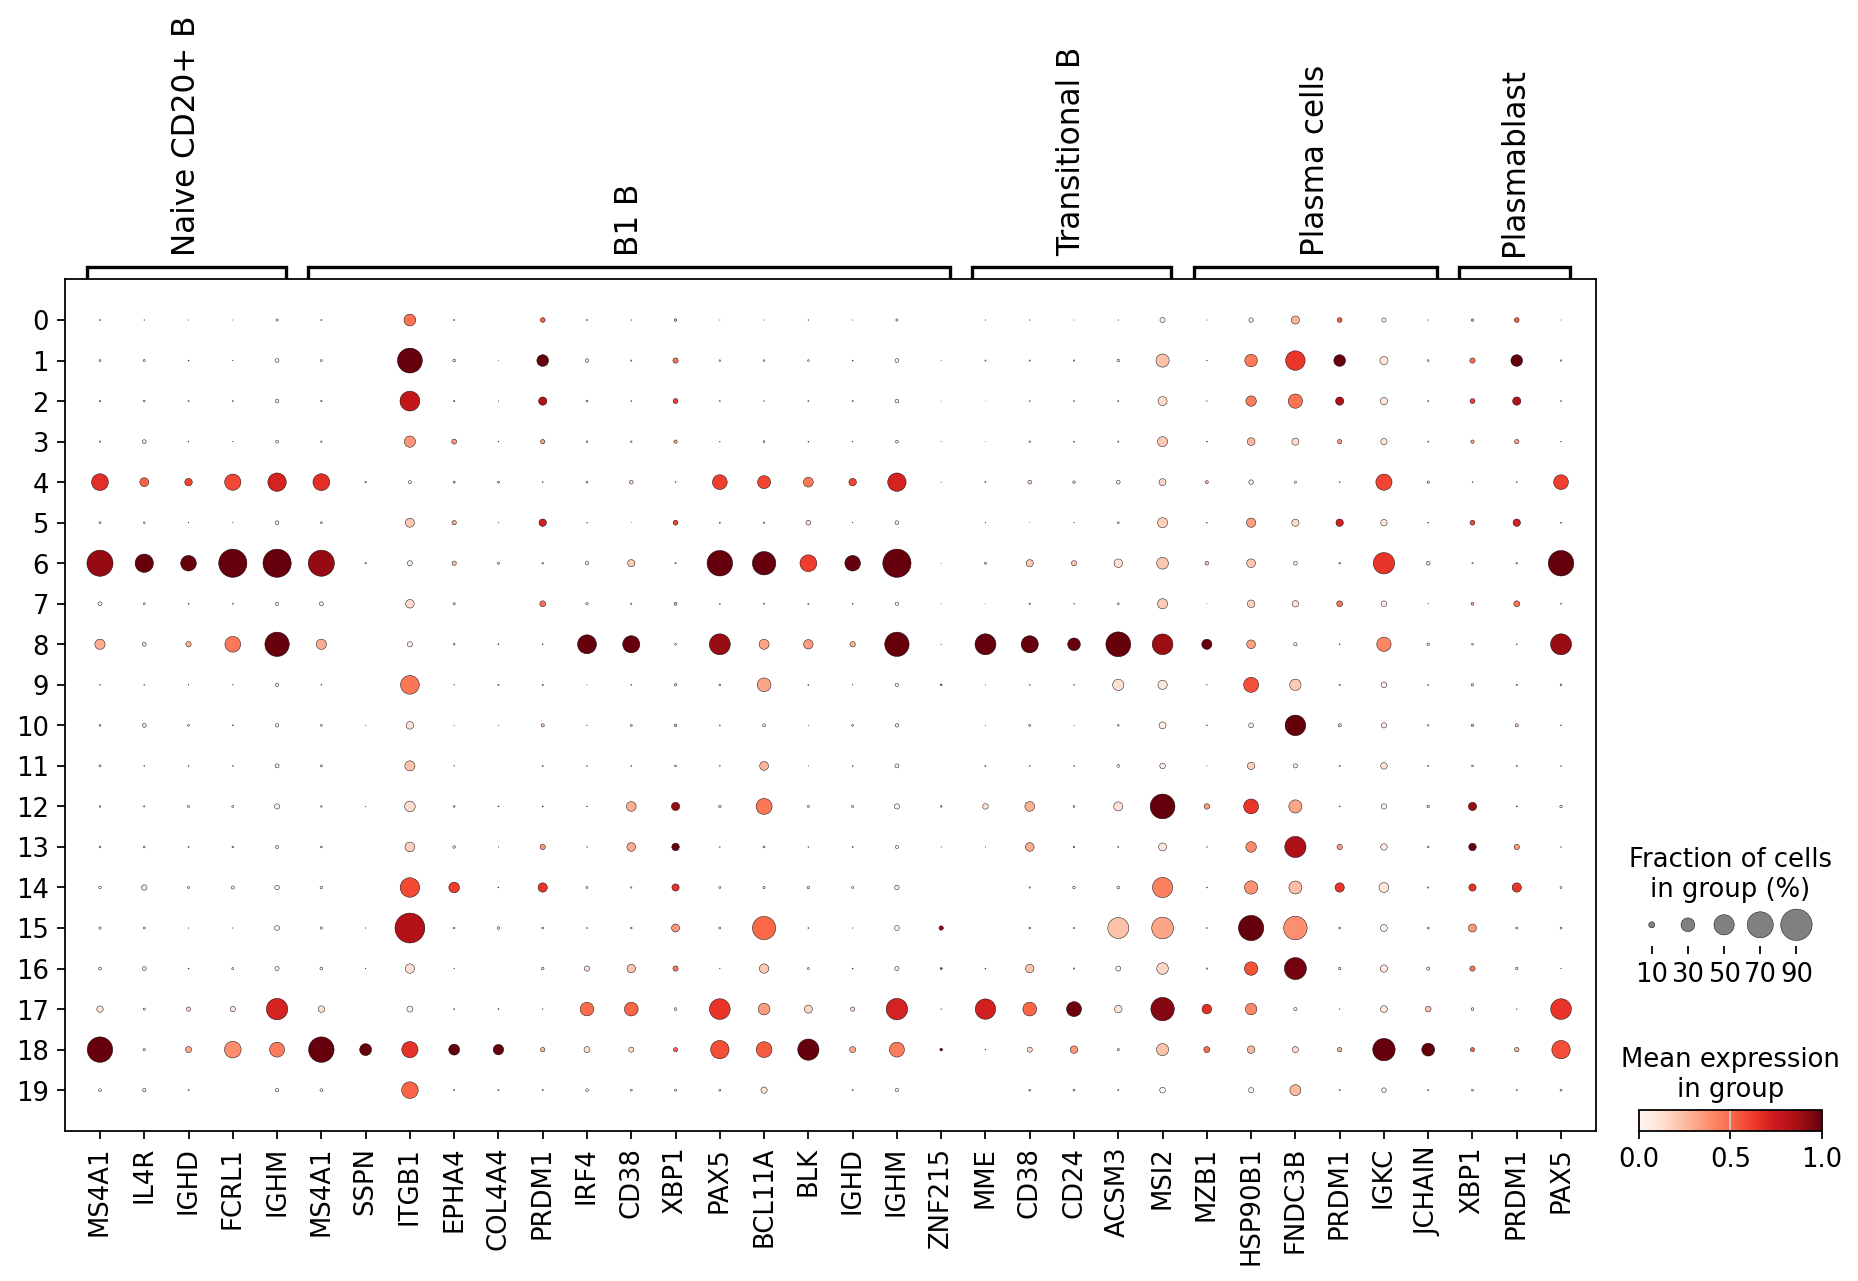

In [25]:
sc.pl.dotplot(
    adata,
    groupby="leiden_2",
    var_names=B_plasma_markers,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [26]:
cl_annotation = {
    "4": "Naive CD20+ B",
    "6": "Naive CD20+ B",
    "18": "Naive CD20+ B",
    "8": "Transitional B",
    "17": "Transitional B"# note that IGHD and IGHM are negative markers for B1 B, in this case more lowly expressed than in the other B cell clusters
}

In [27]:
adata.obs["manual_celltype_annotation"] = adata.obs.leiden_2.map(cl_annotation)

/hps/software/users/ma/research/annavp/miniconda3/envs/sc_py_training/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


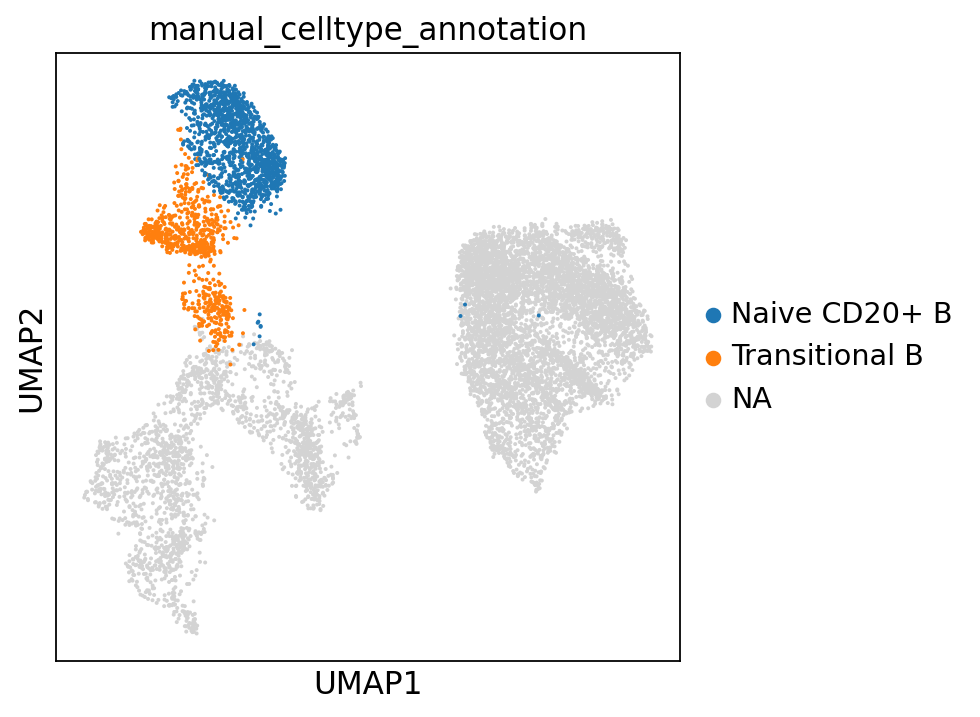

In [28]:
sc.pl.umap(adata, color=["manual_celltype_annotation"])

In [29]:
sc.tl.rank_genes_groups(
    adata, groupby="leiden_2", method="wilcoxon", key_added="dea_leiden_2"
)

/hps/software/users/ma/research/annavp/miniconda3/envs/sc_py_training/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


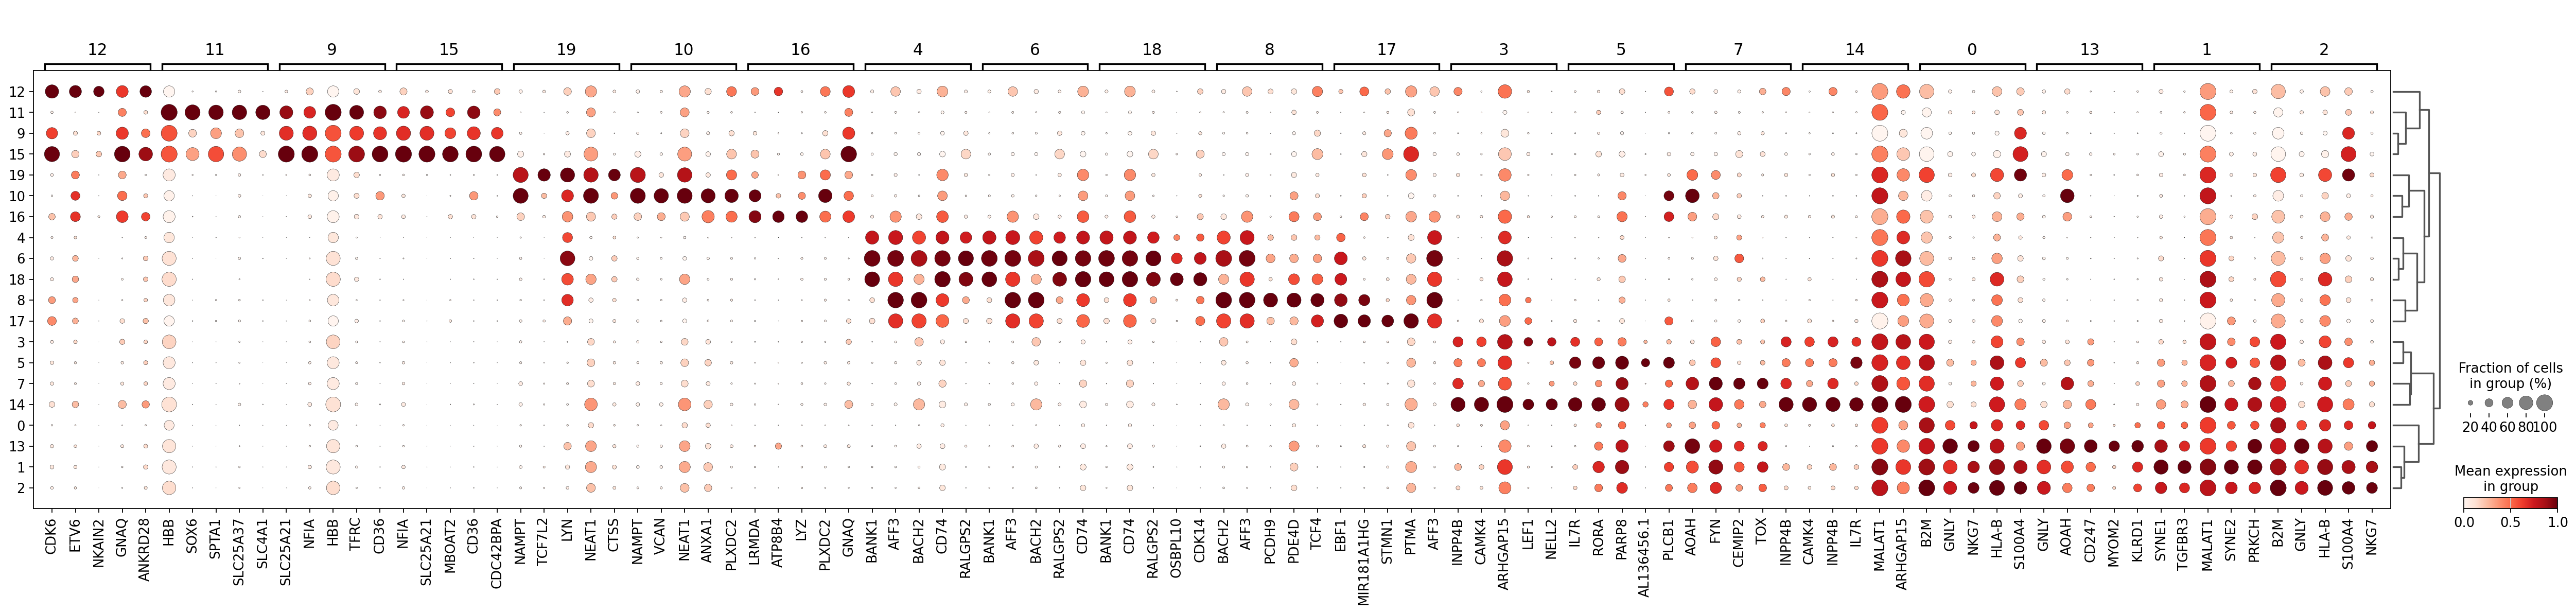

In [30]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_2", standard_scale="var", n_genes=5, key="dea_leiden_2"
)

In [31]:
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_2",
    key_added="dea_leiden_2_filtered",
)

/hps/software/users/ma/research/annavp/miniconda3/envs/sc_py_training/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


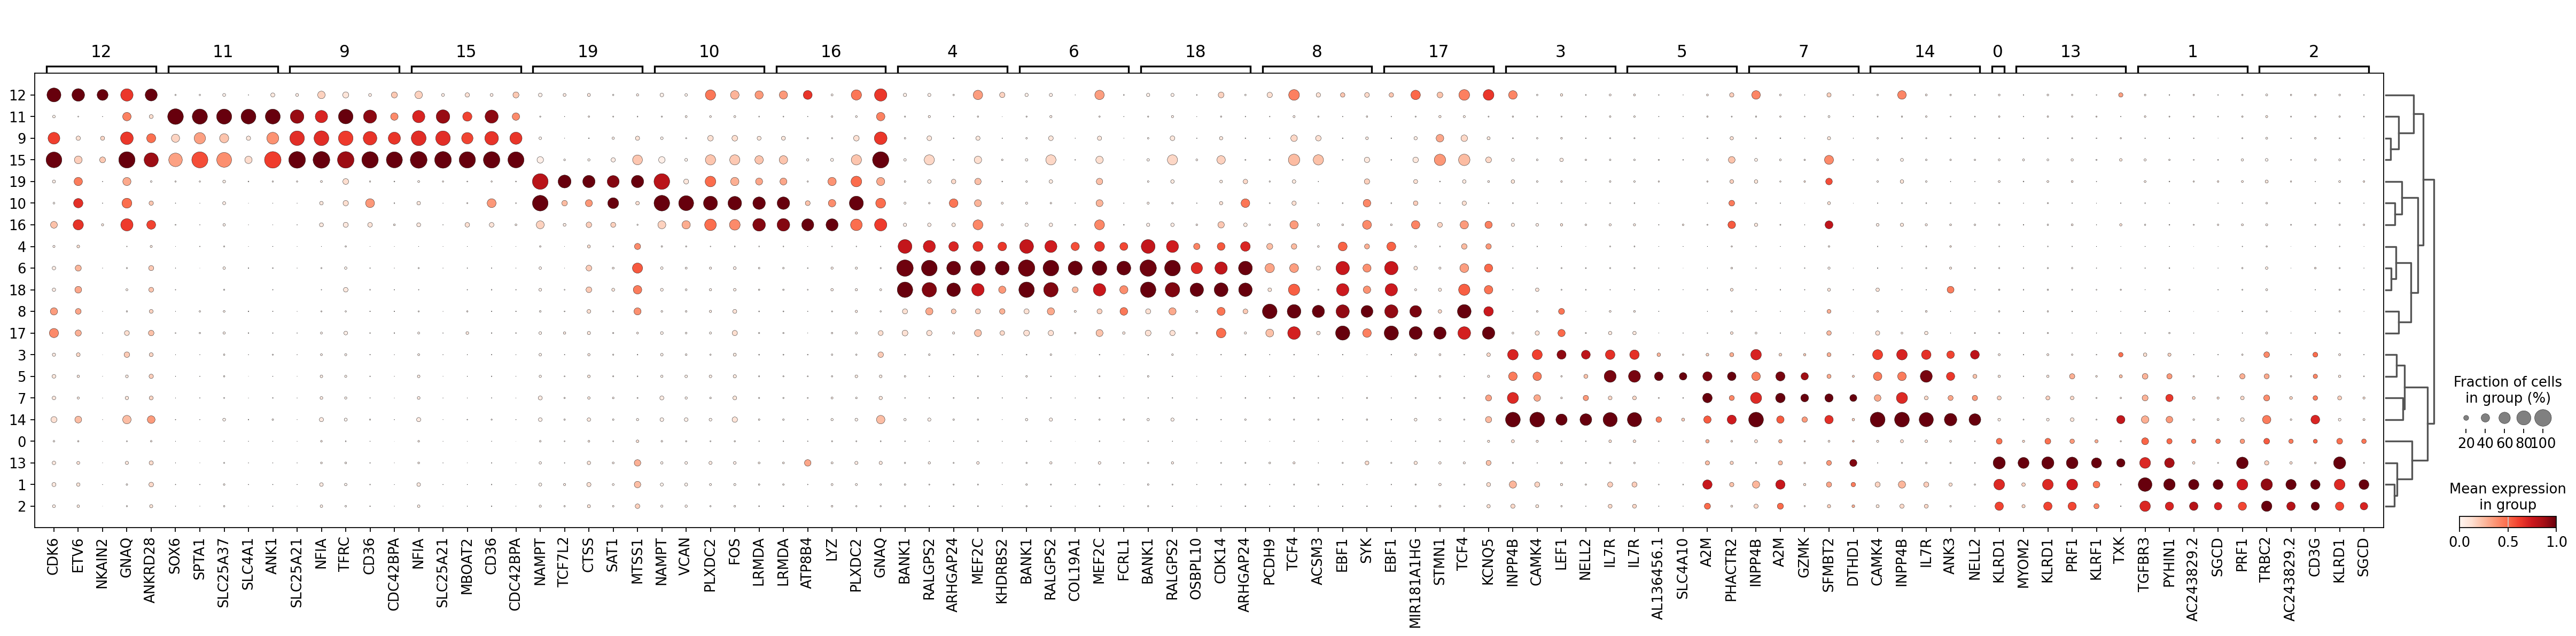

In [32]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_2",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden_2_filtered",
)

Let’s take a look at cluster 12, which seems to have a set of relatively unique markers including CDK6, ETV6, NKAIN2, and GNAQ. Some googling tells us that NKAIN2 and ETV6 are hematopoietic stem cell markers.(NKAIN2 was also present in our list above). In the UMAP we can see that these clusters are expressed throughout cluster 12:

/hps/software/users/ma/research/annavp/miniconda3/envs/sc_py_training/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


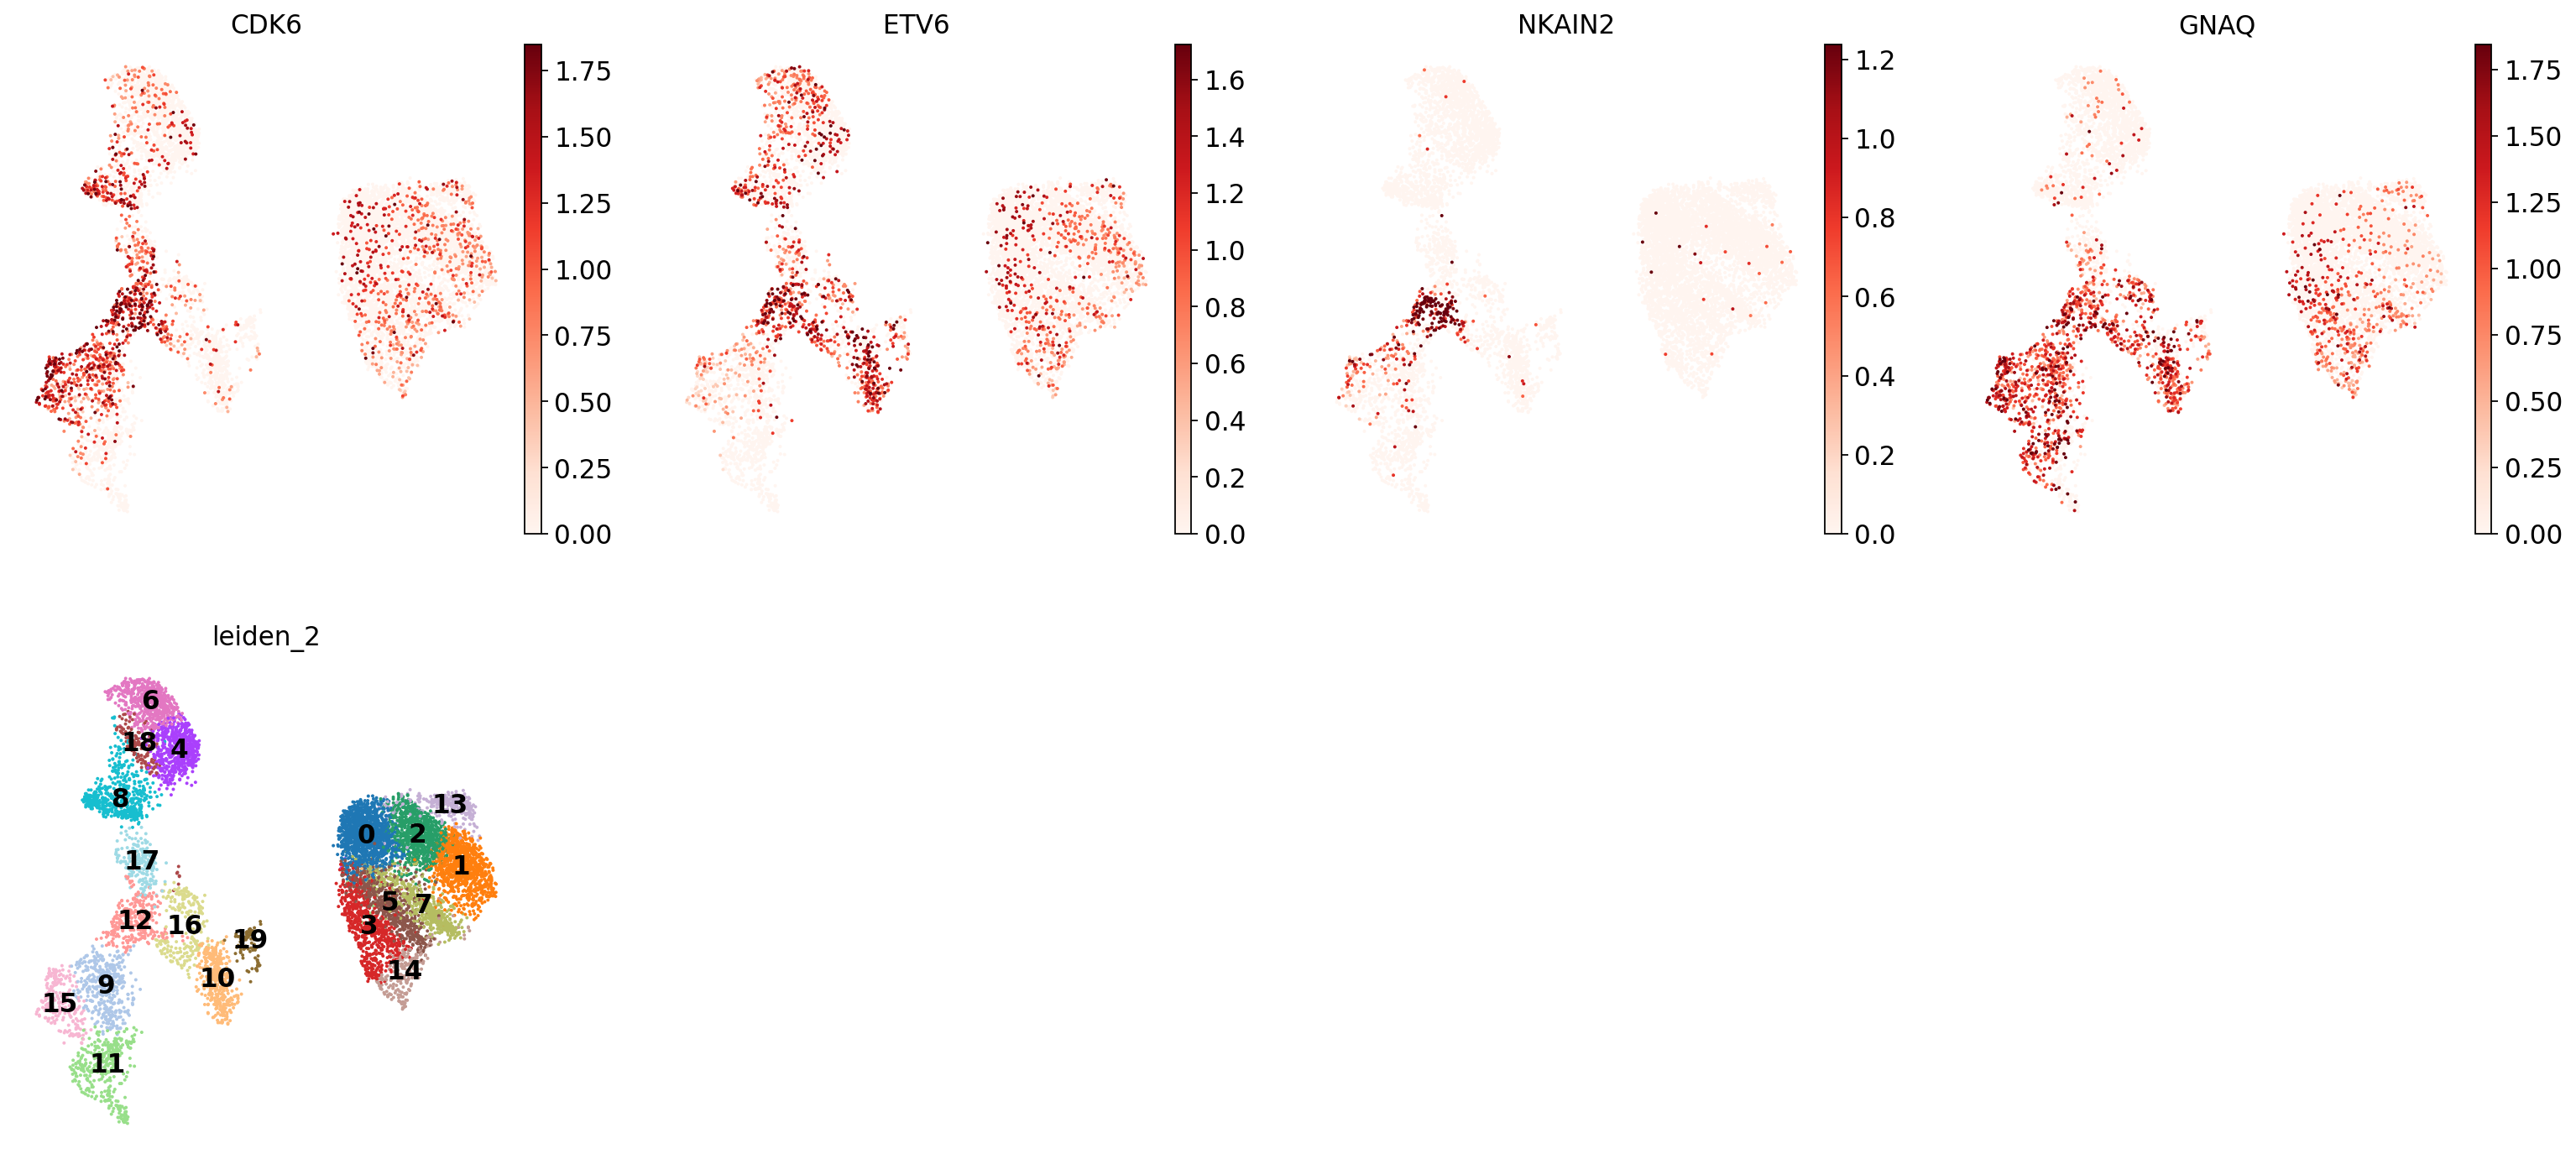

In [33]:
sc.pl.umap(
    adata,
    color=["CDK6", "ETV6", "NKAIN2", "GNAQ", "leiden_2"],
    vmax="p99",
    legend_loc="on data",
    frameon=False,
    cmap="Reds",
)

However, looking at the known markers for the megakaryocyte/erythrocyte progenitors (“MK/E prog”), we see that part of cluster 12 seems to belong to that cell type:

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1","leiden_2"
    ],
    vmax="p99",
    legend_loc="on data",
    frameon=False,
    cmap="Reds",
)

In [ ]:
cl_annotation["12"] = "HSCs + MK/E prog (?)"


In [ ]:
adata.obs["manual_celltype_annotation"] = adata.obs.leiden_2.map(cl_annotation)

In [ ]:
sc.pl.umap(
    adata,
    color=["manual_celltype_annotation","leiden_2"],wspace=0.5)

In [1]:
#time permited : can you try annotate cluster 16? #googling is not only allowed but also encouraged 

In [ ]:
#del adata.uns
#adata.write_h5ad("s4d6_partial_annotation.h5ad")